In [1]:
from huggingface_hub import hf_hub_download
from datasets import Dataset

parquet_path = hf_hub_download(
    repo_id="diffusers-internal-dev/ShotDEAD", filename="shard_00000.parquet", repo_type="dataset"
)
ds = Dataset.from_parquet(parquet_path)
ds

Dataset({
    features: ['id', 'colors', 'Tags', 'Genre', 'Director', 'Cinematographer', 'Production Designer', 'Costume Designer', 'Editor', 'Colorist', 'Actors', 'Shot Time', 'Time Period', 'Color', 'Aspect Ratio', 'Format', 'Frame Size', 'Shot Type', 'Lens Size', 'Composition', 'Lighting', 'Lighting Type', 'Time of Day', 'Interior/Exterior', 'Location Type', 'Set', 'Story Location', 'Filming Location', 'Camera', 'Lens', 'Film Stock / Resolution', 'image', 'Original Aspect Ratio', 'VFX', 'Notes'],
    num_rows: 5000
})

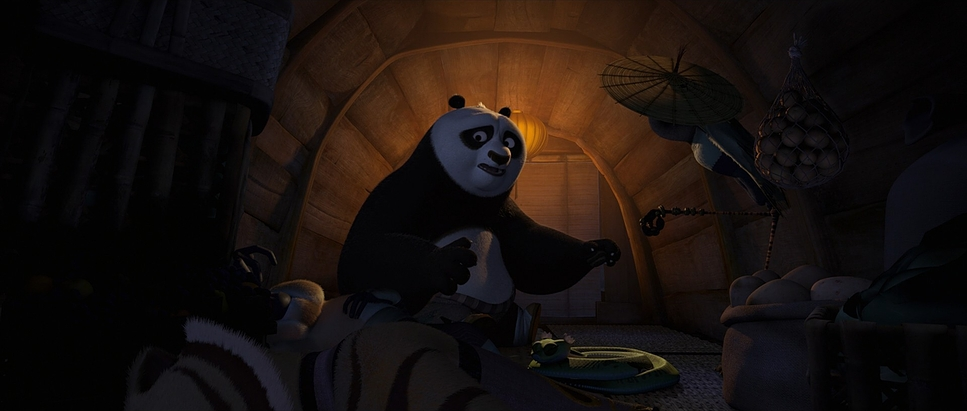

In [2]:
from PIL import Image
import io

Image.open(io.BytesIO(ds[10]["image"]))

In [3]:
from pprint import pprint
import json

pprint(ds[0]["Lighting Type"])

['Daylight']


In [4]:
none_key_map = {
    "Color": ["no_color"],
    "Lighting": ["no_lighting"],
    "Lighting Type": ["no_ligting_type"],
    "Composition": ["no_composition"],
}


def deduce_captions(row):
    def get_detail(key):
        value = row[key]
        if value:
            if isinstance(value, list):
                # Join multiple values into a comma-separated string.
                return ", ".join(value)
            return str(value)
        else:
            # Use a fallback default, optionally replacing placeholders to sound more natural.
            default = none_key_map[key][0]
            return default.replace("no_", "unspecified ").replace("_", " ")

    # Extract details.
    reduced_dict = {}
    for k in none_key_map:
        reduced_dict.update({k: get_detail(k)})

    # Craft a natural language caption.
    json_string = json.dumps(reduced_dict)
    caption = f"""This image has the following shot details:

```json
{json_string}
```
"""

    row["caption"] = caption
    return row


reduced_ds = ds.map(deduce_captions, num_proc=4)
reduced_ds

Dataset({
    features: ['id', 'colors', 'Tags', 'Genre', 'Director', 'Cinematographer', 'Production Designer', 'Costume Designer', 'Editor', 'Colorist', 'Actors', 'Shot Time', 'Time Period', 'Color', 'Aspect Ratio', 'Format', 'Frame Size', 'Shot Type', 'Lens Size', 'Composition', 'Lighting', 'Lighting Type', 'Time of Day', 'Interior/Exterior', 'Location Type', 'Set', 'Story Location', 'Filming Location', 'Camera', 'Lens', 'Film Stock / Resolution', 'image', 'Original Aspect Ratio', 'VFX', 'Notes', 'caption'],
    num_rows: 5000
})

In [5]:
reduced_ds[100]["caption"]

'This image has the following shot details:\n\n```json\n{"Color": "Warm, Desaturated, Yellow", "Lighting": "Hard light, Side light", "Lighting Type": "Daylight, Practical light, Mixed light", "Composition": "Center"}\n```\n'

In [6]:
def prepare_conversations(row):
    row["messages"] = [
        {
            "role": "user",
            "content": [{"type": "text", "text": "Provide shot details of the image"}, {"type": "image"}],
        },
        {"role": "assistant", "content": [{"type": "text", "text": row["caption"]}]},
    ]
    return row


reduced_ds_with_messages = reduced_ds.map(prepare_conversations, num_proc=4)
reduced_ds_with_messages

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'colors', 'Tags', 'Genre', 'Director', 'Cinematographer', 'Production Designer', 'Costume Designer', 'Editor', 'Colorist', 'Actors', 'Shot Time', 'Time Period', 'Color', 'Aspect Ratio', 'Format', 'Frame Size', 'Shot Type', 'Lens Size', 'Composition', 'Lighting', 'Lighting Type', 'Time of Day', 'Interior/Exterior', 'Location Type', 'Set', 'Story Location', 'Filming Location', 'Camera', 'Lens', 'Film Stock / Resolution', 'image', 'Original Aspect Ratio', 'VFX', 'Notes', 'caption', 'messages'],
    num_rows: 5000
})

In [7]:
reduced_ds_with_messages[0]["messages"]

[{'content': [{'text': 'Provide shot details of the image', 'type': 'text'},
   {'text': None, 'type': 'image'}],
  'role': 'user'},
 {'content': [{'text': 'This image has the following shot details:\n\n```json\n{"Color": "Blue", "Lighting": "Soft light", "Lighting Type": "Daylight", "Composition": "Left heavy"}\n```\n',
    'type': 'text'}],
  'role': 'assistant'}]

In [8]:
reduced_ds_with_messages.features

{'id': Value(dtype='string', id=None),
 'colors': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Tags': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Genre': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Director': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Cinematographer': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Production Designer': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Costume Designer': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Editor': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Colorist': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Actors': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Shot Time': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'Time Period': Sequence(feature=V

In [9]:
include_cols = {"image", "caption", "messages"}
all_cols = set(reduced_ds_with_messages.features.keys())

remove_cols = all_cols - include_cols
remove_cols

{'Actors',
 'Aspect Ratio',
 'Camera',
 'Cinematographer',
 'Color',
 'Colorist',
 'Composition',
 'Costume Designer',
 'Director',
 'Editor',
 'Film Stock / Resolution',
 'Filming Location',
 'Format',
 'Frame Size',
 'Genre',
 'Interior/Exterior',
 'Lens',
 'Lens Size',
 'Lighting',
 'Lighting Type',
 'Location Type',
 'Notes',
 'Original Aspect Ratio',
 'Production Designer',
 'Set',
 'Shot Time',
 'Shot Type',
 'Story Location',
 'Tags',
 'Time Period',
 'Time of Day',
 'VFX',
 'colors',
 'id'}

In [10]:
reduced_ds_with_messages = reduced_ds_with_messages.remove_columns(list(remove_cols))
reduced_ds_with_messages

Dataset({
    features: ['image', 'caption', 'messages'],
    num_rows: 5000
})

In [11]:
repo_id = "diffusers-internal-dev/ShotDEAD-single-shard"
reduced_ds_with_messages.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sayak/.pyenv/versions/3.10.12/envs/diffusers/lib/python3.10/site-packages/huggingface_hub/lfs.py:337: UserWarning: hf_transfer is enabled but does not support uploading from bytes or BinaryIO, falling back to regular upload
  warnings.warn(


Creating parquet from Arrow format:   0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/datasets/diffusers-internal-dev/ShotDEAD-single-shard/commit/777761cf7fbef63f03aab70c8558408d031ee962', commit_message='Upload dataset', commit_description='', oid='777761cf7fbef63f03aab70c8558408d031ee962', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/diffusers-internal-dev/ShotDEAD-single-shard', endpoint='https://huggingface.co', repo_type='dataset', repo_id='diffusers-internal-dev/ShotDEAD-single-shard'), pr_revision=None, pr_num=None)

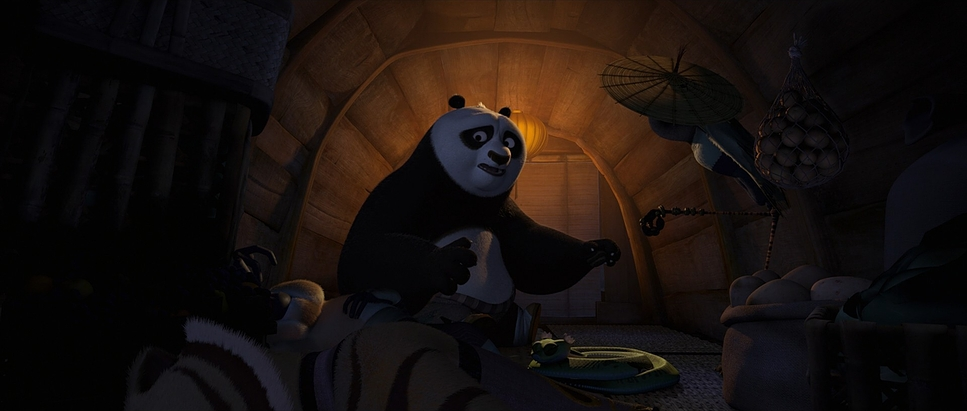

In [12]:
Image.open(io.BytesIO(reduced_ds_with_messages[10]["image"]))

Follow this guide to fine-tune a VLM (PaliGemma?), following [this guide](https://huggingface.co/docs/trl/en/sft_trainer#extending-sfttrainer-for-vision-language-models).